1.data cleaning

In [21]:
## 1. Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    FunctionTransformer, OneHotEncoder,OrdinalEncoder,
    StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
)
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



In [22]:
## 2. Define relative file paths
RAW_DATA_PATH = Path('../data/raw/alcohol_consumption_raw.csv')         # Relative path to the raw dataset
CLEANED_DATA_PATH = Path('../data/interim/alcohol_consumption_cleaned.csv')  # Relative path to save the cleaned dataset

## 3. Load the raw dataset using a relative path
df_raw = pd.read_csv(RAW_DATA_PATH)

print("Shape of raw dataset:", df_raw.shape)
df_raw.head()



Shape of raw dataset: (991346, 24)


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1,1,120,...,126,92,17.1,1,1.0,21,35,40,1,Y
1,Male,30,180,80,89.0,0.9,1.2,1,1,130,...,148,121,15.8,1,0.9,20,36,27,3,N
2,Male,40,165,75,91.0,1.2,1.5,1,1,120,...,74,104,15.8,1,0.9,47,32,68,1,N
3,Male,50,175,80,91.0,1.5,1.2,1,1,145,...,104,106,17.6,1,1.1,29,34,18,1,N
4,Male,50,165,60,80.0,1.0,1.2,1,1,138,...,117,104,13.8,1,0.8,19,12,25,1,N


In [23]:
#identifying missing values
df_raw['waistline'] = df_raw['waistline'].replace(999, np.nan)
df_raw['gamma_GTP'] = df_raw['gamma_GTP'].replace(999, np.nan)

In [24]:
# new features constructed rederring to medical doamin knowledge

df_newf = df_raw.copy()


df_newf['BMI'] = df_newf['weight'] / ((df_newf['height']/100)**2)
df_newf['pulse_pressure'] = df_newf['SBP'] - df_newf['DBP']
df_newf['AST_ALT_ratio'] = df_newf['SGOT_AST'] / df_newf['SGOT_ALT']

waist_thresh = df_newf['sex'].map({0: 90, 1: 80})
risk_waist = df_newf['waistline'] > waist_thresh
risk_bp = (df_newf['SBP'] >= 130) | (df_newf['DBP'] >= 85)
risk_tg = df_newf['triglyceride'] >= 150
risk_hdl = df_newf['HDL_chole'] < df_newf['sex'].map({1: 40, 2: 50})
risk_glu = df_newf['BLDS'] >= 100

df_newf['metabolic_risk_count'] = (
    risk_waist.astype(int)
    + risk_bp.astype(int)
    + risk_tg.astype(int)
    + risk_hdl.astype(int)
    + risk_glu.astype(int)
)

df_newf.to_csv('../data/smoking_driking_dataset_with_medical_features.csv')
df_newf.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,BMI,pulse_pressure,AST_ALT_ratio,metabolic_risk_count
0,Male,35,170,75,90.0,1.0,1.0,1,1,120,...,1.0,21,35,40.0,1,Y,25.951557,40,0.600000,0
1,Male,30,180,80,89.0,0.9,1.2,1,1,130,...,0.9,20,36,27.0,3,N,24.691358,48,0.555556,2
2,Male,40,165,75,91.0,1.2,1.5,1,1,120,...,0.9,47,32,68.0,1,N,27.548209,50,1.468750,0
3,Male,50,175,80,91.0,1.5,1.2,1,1,145,...,1.1,29,34,18.0,1,N,26.122449,58,0.852941,1
4,Male,50,165,60,80.0,1.0,1.2,1,1,138,...,0.8,19,12,25.0,1,N,22.038567,56,1.583333,2


In [25]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
# VAL_SIZE = 0.5 #out of test set
X = df_newf.drop(columns=['DRK_YN'])
y = df_newf['DRK_YN']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = TEST_SIZE, random_state = 1)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = VAL_SIZE, random_state= 1)

y_train = y_train.to_frame(name='y_train')
# y_val = y_val.to_frame(name='y_val')
y_test = y_test.to_frame(name='y_test')


# X = {'X_train':X_train, 'X_test':X_test}
# y = {'y_train':y_train, 'y_test':y_test}


# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )
# # Then split 25% from the 80% (i.e., 20% of the total) as the validation set
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.25, random_state=42
# )

X_train.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,BMI,pulse_pressure,AST_ALT_ratio,metabolic_risk_count
985812,Male,60,175,65,78.0,1.2,1.2,1,1,125,...,1,0.9,23,24,45.0,2,21.224490,45,0.958333,0
96964,Female,55,155,60,85.1,1.2,0.8,1,1,128,...,1,0.6,20,18,19.0,1,24.973985,41,1.111111,2
47301,Male,30,175,75,89.2,1.5,1.5,1,1,131,...,1,0.9,17,15,26.0,2,24.489796,59,1.133333,1
129946,Female,50,160,55,71.0,1.2,1.0,1,1,133,...,1,0.8,19,11,14.0,1,21.484375,59,1.727273,2
539779,Male,55,175,65,88.0,1.5,1.5,1,1,145,...,1,0.8,32,17,70.0,2,21.224490,60,1.882353,3


In [26]:
df_numeric = df_raw.select_dtypes(include=[np.number])


In [27]:
# 3. Set the quantile threshold
q1, q2 = 0.0001, 0.9999

# 4. Build a boolean matrix to flag each cell as an outlier
mask = pd.DataFrame(index=df_raw.index)
for col in df_numeric.columns:
    lower = df_raw[col].quantile(q1)
    upper = df_raw[col].quantile(q2)
    mask[col] = (df_raw[col] < lower) | (df_raw[col] > upper)

# 5. Filter rows with at least one outlier
has_outlier = mask.any(axis=1)
df_out = df_raw[has_outlier].copy()

# 6. Count the number of outliers per row in the subset
df_out['n_outlier_cols'] = mask.loc[has_outlier].sum(axis=1)
df_out['prop_outlier_cols'] = mask.loc[has_outlier].mean(axis=1)
df_out['outlier_cols'] = (
    mask.loc[has_outlier]
    .apply(lambda row: row.index[row].tolist(), axis=1)
)

# 7. View the results
print(f"Total of {len(df_out)} rows with at least one outlier (equivalent to {has_outlier.mean():.1%})")
print(df_out[['n_outlier_cols', 'prop_outlier_cols']].head())

# 8. Save the subset including outlier counts
df_out.to_csv(f'../data/all_outliers_with_counts_{q1}.csv', index=False)
print(f"../data/all_outliers_with_counts_{q1}.csv")


2170 rows with at least one outlier (equivalent to 0.2%)
      n_outlier_cols  prop_outlier_cols
416                1           0.045455
2402               1           0.045455
2576               1           0.045455
3453               1           0.045455
3627               1           0.045455
../data/all_outliers_with_counts_0.0001.csv


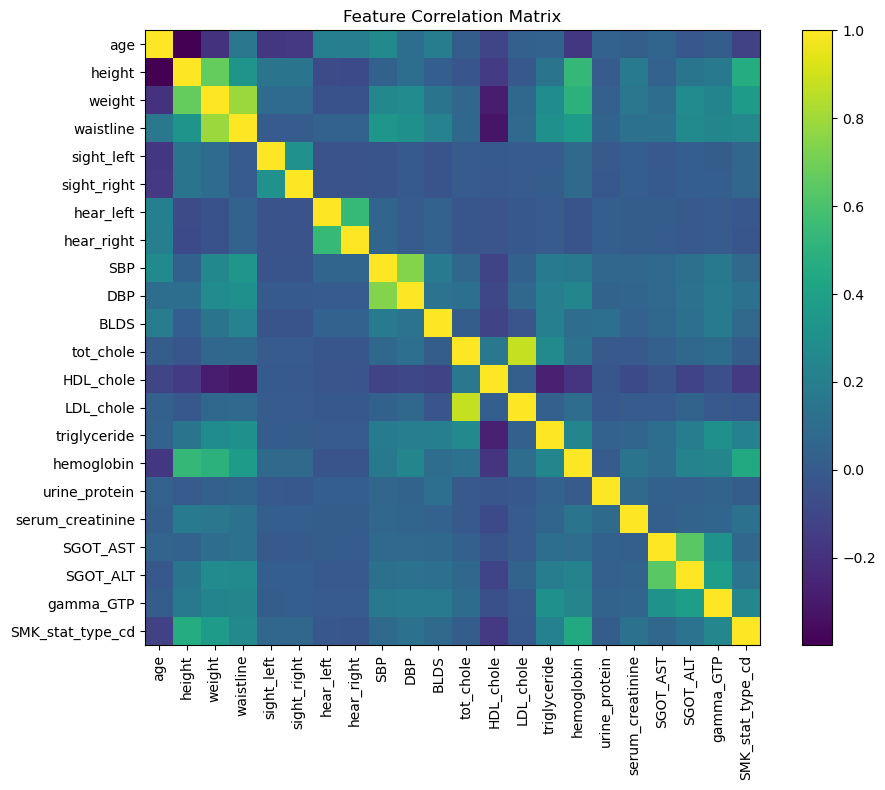

Because correlation coefficient |ρ| > 0.9, features to drop: []
Reduced dataset shape: (991346, 22)


In [ ]:


# 3. Compute the correlation matrix
corr_matrix = df_numeric.corr()

# 4. Plot a heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(im)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 5. Identify highly correlated feature pairs (|ρ| > 0.9) and mark features to drop
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > threshold)]
print("Because correlation coefficient |ρ| > 0.9, features to drop:", to_drop)

# 6. Drop the highly correlated features
df_reduced = df_numeric.drop(columns=to_drop)
print("Reduced dataset shape:", df_reduced.shape)

# 7. (Optional) Example merge: combine a pair of highly correlated features by averaging
# Assuming 'feat1' and 'feat2' are highly correlated:
# if {'feat1', 'feat2'}.issubset(df_numeric.columns):
#     df_numeric['feat1_2_mean'] = df_numeric[['feat1','feat2']].mean(axis=1)
#     df_numeric.drop(columns=['feat1','feat2'], inplace=True)



In [29]:

def compare_all_descriptive_stats(
    df_dict: dict,
    stats_to_include=('count','mean','std','min','25%','50%','75%','max'),
    cmap='vlag',
    figsize_per_metric=(8, 0.4)
):
    """
    For each DataFrame in df_dict, compute df.describe().T,
    then concatenate them into a single MultiIndex DataFrame
    and plot a heatmap for each requested statistic.
    
    Parameters
    ----------
    df_dict : dict[str, pandas.DataFrame]
        Mapping from dataset name to DataFrame.
    stats_to_include : tuple[str]
        Which describe() metrics to include (must be columns of describe()).
    cmap : str
        A seaborn-compatible colormap for the heatmaps.
    figsize_per_metric : tuple[float, float]
        Base figure size per metric: (width, height_per_feature).
    """
    # 1) Compute describe().T for each DataFrame
    stats = {name: df.describe().T for name, df in df_dict.items()}
    
    # 2) Concatenate along columns, making keys the dataset names
    #    Result: columns is a MultiIndex [dataset, stat]
    combined = pd.concat(stats, axis=1)
    
    # 3) For each stat, slice out combined.xs(stat, axis=1, level=1)
    for stat in stats_to_include:
        # get DataFrame of shape (n_features × n_datasets)
        df_stat = combined.xs(stat, axis=1, level=1)
        
        # 4) Plot heatmap
        n_features = df_stat.shape[0]
        height = figsize_per_metric[1] * n_features
        plt.figure(figsize=(figsize_per_metric[0], height))
        sns.heatmap(
            df_stat,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            cbar_kws={'label': stat}
        )
        plt.title(f"{stat} across datasets")
        plt.xlabel("Dataset")
        plt.ylabel("Feature")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


def summarize_target_counts(y_dict: dict):
    """
    Given a dict of name -> pd.Series (with values like 'Y'/'N'),
    print and plot the counts of each category.

    Parameters
    ----------
    y_dict : dict[str, pd.Series]
        Mapping from label (e.g. 'train', 'val', 'test') to the target series.
    """
    for name, y in y_dict.items():
        # 1) Compute raw counts
        counts = y.value_counts(dropna=False)
        
        # 2) Print table
        print(f"--- {name} target distribution ---")
        print(counts)
        print(f"Total samples: {len(y)}\n")
        
        # 3) Optional: plot bar chart
        plt.figure(figsize=(4,3))
        counts.plot(kind='bar')
        plt.title(f"{name} target counts")
        plt.xlabel("Class")
        plt.ylabel("Frequency")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


In [30]:

def plot_feature_histograms(
    df_dict: dict,
    features: list = None,
    bins: int = 20,
    figsize_per_plot: tuple = (4, 3),
    hist_kws: dict = None
):
    """
    Plot per-feature histograms for multiple datasets, aligning each feature row.

    Parameters
    ----------
    df_dict : dict[str, pd.DataFrame]
        Mapping names (e.g. 'train', 'val', 'test') to DataFrames.
    features : list[str], optional
        Which columns to plot. Default: intersection of all df.columns.
    bins : int or sequence, default 20
        Number of bins or custom bin edges for histograms.
    figsize_per_plot : (width, height)
        Size for each individual subplot in inches.
    hist_kws : dict, optional
        Additional kwargs passed to plt.hist or sns.histplot.
    """
    # 1) Determine features to plot
    if features is None:
        # Intersection ensures all DataFrames have the column
        features = list(
            set.intersection(*[set(df.columns) for df in df_dict.values()])
        )

    n_feats = len(features)
    n_dsets = len(df_dict)
    names = list(df_dict.keys())

    # 2) Create grid of subplots
    fig, axes = plt.subplots(
        n_feats, n_dsets,
        figsize=(figsize_per_plot[0]*n_dsets,
                 figsize_per_plot[1]*n_feats),
        sharex='col', sharey='row'
    )

    # 3) Loop over features (rows) and datasets (columns)
    for row_idx, feat in enumerate(features):
        for col_idx, ds_name in enumerate(names):
            ax = axes[row_idx, col_idx] if n_feats > 1 else axes[col_idx]
            data = df_dict[ds_name][feat].dropna()

            # Choose seaborn.histplot for styling, fallback to plt.hist
            if hist_kws is None:
                hist_kws = {}
            sns.histplot(
                data,
                bins=bins,
                ax=ax,
                kde=False,
                **hist_kws
            )  # seaborn.histplot :contentReference[oaicite:0]{index=0}

            # Only label left edge of each row and bottom edge of each column
            if row_idx == n_feats - 1:
                ax.set_xlabel(feat)
            else:
                ax.set_xlabel('')
                ax.set_xticklabels([])
            if col_idx == 0:
                ax.set_ylabel('Count')
            else:
                ax.set_ylabel('')

            # Title only for top row
            if row_idx == 0:
                ax.set_title(ds_name)

    plt.tight_layout()
    plt.show()


In [31]:
#columns to be transformed


num_cols = df_newf.select_dtypes(include='number').columns
skews = df_newf[num_cols].skew()        # skew
kurts = df_newf[num_cols].kurtosis()    # kurtosis
print(skews)
to_transform = skews[skews.abs() > 1].index.tolist()
to_transform += kurts[kurts > 3].index.tolist()
to_transform = list(set(to_transform))
print("columns to transform:", to_transform)

print(df_newf.columns)


age                       0.153653
height                   -0.022737
weight                    0.576557
waistline                 0.166376
sight_left                9.994626
sight_right              10.033647
hear_left                 5.365084
hear_right                5.463013
SBP                       0.482060
DBP                       0.400034
BLDS                      4.617377
tot_chole                 1.556882
HDL_chole               104.577635
LDL_chole                 5.251739
triglyceride              6.529373
hemoglobin               -0.383988
urine_protein             5.672491
serum_creatinine        111.022058
SGOT_AST                150.491690
SGOT_ALT                 50.038872
gamma_GTP                 6.951555
SMK_stat_type_cd          0.831428
BMI                       0.491674
pulse_pressure            0.677200
AST_ALT_ratio           572.866875
metabolic_risk_count      0.508137
dtype: float64
columns to transform: ['sight_right', 'SGOT_AST', 'hear_left', 'BLDS', 'AST

In [32]:
cols_to_impute = ['gamma_GTP', 'waistline']

impute_ct = ColumnTransformer([
    ('imp_sel', SimpleImputer(), cols_to_impute)
], remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')  # Keep other columns unchanged

imputers = [
    # SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='median'),
    KNNImputer(n_neighbors=5)                # KNN imputation based on similar samples :contentReference[oaicite:1]{index=1}
]


In [33]:
# categorical change




def transform_sight(X):
    df = pd.DataFrame(X, columns=['sight_left','sight_right'])
    return pd.DataFrame({
        'sight_any_9_9': ((df['sight_left']==9.9)|(df['sight_right']==9.9)).astype(int),
        # 'sight_both_9_9': ((df['sight_left']==9.9)&(df['sight_right']==9.9)).astype(int)
    })

def transform_hear(X):
    df = pd.DataFrame(X, columns=['hear_left','hear_right'])
    return pd.DataFrame({
        'hear_any_2': ((df['hear_left']==2)|(df['hear_right']==2)).astype(int),
        # 'hear_both_2': ((df['hear_left']==2)&(df['hear_right']==2)).astype(int)
    })

def transform_urine(X):
    # 1) 统一获取一维 numpy 数组
    if hasattr(X, "values"):          # X is likely a DataFrame
        arr = X.values.flatten()
    else:                             # X is already an ndarray
        arr = np.asarray(X).flatten()
    # 2) 做映射
    mapping = {1:5, 2:15, 3:30, 4:100, 5:300, 6:1000}
    mapped = [mapping.get(int(v), np.nan) for v in arr]
    # 3) 返回形状 (n_samples,1) 的 DataFrame
    return pd.DataFrame(
        {"urine_protein_mapped": mapped},
        index=getattr(X, "index", None)
    )





In [34]:
scalers = [
    StandardScaler(),
    RobustScaler()
]

In [35]:
feature_selectors = [
     VarianceThreshold(threshold=0.0),
     SelectKBest(f_classif, k=20),
   #   SelectFromModel(LogisticRegression(penalty='l1',solver='saga'), max_features=20)
  ]



In [36]:
sight_transformer = FunctionTransformer(transform_sight, validate=False)
hear_transformer = FunctionTransformer(transform_hear, validate=False)
urine_transformer = FunctionTransformer(transform_urine, validate=False)

smk_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sex_encoder = OrdinalEncoder()

cat_transformer = ColumnTransformer([
    ('sight', sight_transformer, ['sight_left','sight_right']),
    ('hear', hear_transformer, ['hear_left','hear_right']),
    ('urine', urine_transformer, ['urine_protein']),
    ('smk', smk_encoder, ['SMK_stat_type_cd']),
    ('sex',sex_encoder, ['sex'])
], remainder='passthrough',verbose_feature_names_out=False ).set_output(transform='pandas')


# nonlinear_methods = ['box-cox', 'quantile-uniform', 'quantile-normal']


In [37]:
nonlinear_cols = ['LDL_chole', 'gamma_GTP', 'serum_creatinine', 'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole', 'triglyceride', 'HDL_chole', 'urine_protein_mapped', 'SGOT_AST', 'BLDS']
# print(df_newf[nonlinear_cols].dtypes)

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

ct_boxcox = ColumnTransformer([
    ('bc', PowerTransformer(method='box-cox'), nonlinear_cols)
], remainder='passthrough',verbose_feature_names_out=False )

# ct_yeojohnson = ColumnTransformer([
#     ('yj', PowerTransformer(method='yeo-johnson'), nonlinear_cols)
# ], remainder='passthrough')

ct_quantile = ColumnTransformer([
    ('qt', QuantileTransformer(output_distribution='normal', random_state=0), nonlinear_cols)
], remainder='passthrough',verbose_feature_names_out=False ).set_output(transform='pandas')

nonlinear_methods = [ct_boxcox,ct_quantile]



In [ ]:
# def debug_non_numeric(X):
#     # Only print on the first call
#     if isinstance(X, pd.DataFrame):
#         non_num = X.select_dtypes(exclude=[np.number]).columns.tolist()
#         print("⚠️ Non-numeric columns:", non_num)
#     else:
#         # If an array is passed in, we can’t check by column names
#         print("⚠️ Input is not a DataFrame, dtype =", X.dtype)
#     return X

In [39]:
pipe = Pipeline([
    ('impute', impute_ct),
    ('cat_transform', cat_transformer),
    # ('nonlinear_transform', SkewKurtosisTransformer()),
    ('nonlinear_transform','passthrough'),
    ('linear_transform','passthrough'),
    ('feature_selection','passthrough'),
    # ('debug',   FunctionTransformer(debug_non_numeric, validate=False)),
    ('clf',MLPClassifier(max_iter=500, random_state=42
                        #  early_stopping=True,       # Automatically split a portion of training data as validation using validation_fraction
    # validation_fraction=0.1,   # Reserve 10% of training data as the 'early-stopping' validation set
    # n_iter_no_change=5,        # Stop after 5 consecutive iterations with no loss decrease
    # tol=1e-4
    )  )                  # Threshold for determining 'no decrease'))
    ]
)



In [41]:
print(pipe.get_params().keys())


dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'impute', 'cat_transform', 'nonlinear_transform', 'linear_transform', 'feature_selection', 'clf', 'impute__force_int_remainder_cols', 'impute__n_jobs', 'impute__remainder', 'impute__sparse_threshold', 'impute__transformer_weights', 'impute__transformers', 'impute__verbose', 'impute__verbose_feature_names_out', 'impute__imp_sel', 'impute__imp_sel__add_indicator', 'impute__imp_sel__copy', 'impute__imp_sel__fill_value', 'impute__imp_sel__keep_empty_features', 'impute__imp_sel__missing_values', 'impute__imp_sel__strategy', 'cat_transform__force_int_remainder_cols', 'cat_transform__n_jobs', 'cat_transform__remainder', 'cat_transform__sparse_threshold', 'cat_transform__transformer_weights', 'cat_transform__transformers', 'cat_transform__verbose', 'cat_transform__verbose_feature_names_out', 'cat_transform__sight', 'cat_transform__hear', 'cat_transform__urine', 'cat_transform__smk', 'cat_transform__sex', 'cat_transform__sight__accept_

In [ ]:
param_grid = {
    # Missing value imputation strategy
    'impute__imp_sel': imputers,
    # Non-linear transformation methods
    'nonlinear_transform': nonlinear_methods,
    'linear_transform': scalers,
    # Raw feature selection method
    'feature_selection': feature_selectors,
    # MLP hyperparameters
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'clf__hidden_layer_sizes': [(50,), (100,)],
    'clf__alpha':              [1e-4, 1e-3],
    'clf__learning_rate_init': [1e-4, 1e-3]
}

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

def debug_auc(estimator, X, y):
    # Note: the estimator has already been fitted here
    prob = estimator.predict_proba(X)[:, 1]
    sc = roc_auc_score(y, prob)
    print(f"  >>> fold AUC = {sc:.4f}")
    return sc

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import sys

from sklearn.model_selection import GridSearchCV
from contextlib import redirect_stdout

grid = GridSearchCV(
    pipe, param_grid,
    cv=3,
    # scoring='roc_auc',
    scoring=debug_auc,
    n_jobs=-1,
    error_score='raise',  # Raise an exception on the first error
    verbose=2
)

# sh = HalvingGridSearchCV(
#     pipe,
#     param_grid,
#     factor=2,                      # Eliminate half of candidates each iteration, doubling resources next round
#     resource='clf__n_estimators',  # Use n_estimators as the "resource"
#     max_resources=1000,
#     cv=3,
#     scoring='neg_log_loss',
#     n_jobs=-1,
#     verbose=2
# )

logfile = open('grid_verbose.log', 'w')

class Tee:
    def __init__(self, *streams):
        self.streams = streams
    def write(self, data):
        for s in self.streams:
            s.write(data)
    def flush(self):
        for s in self.streams:
            s.flush()

# 3. Create a tee object that writes output to both the console and a file
tee = Tee(sys.stdout, logfile)

# 4. Run grid.fit within the redirect_stdout context so output goes to both places
with redirect_stdout(tee):
    grid.fit(X_train, y_train)

print("Best score:  ", grid.best_score_)
print("Best params: ", grid.best_params_)
print("Best CV score:", grid.best_score_)
print("Best estimator pipeline:\n", grid.best_estimator_)

df = pd.DataFrame(grid.cv_results_)
display(df[[
    'params',
    'mean_test_score','std_test_score',
    'mean_train_score','std_train_score',
    'mean_fit_time','mean_score_time'
]])

# 9. Evaluate on the test set ————————————————————————————
test_score = grid.score(X_test, y_test)
print("Test AUC:    ", test_score)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/

  >>> fold AUC = 0.8209
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('qt',
                                 QuantileTransformer(output_distribution='normal',
                                                     random_state=0),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 1.9min
  >>> fold AUC = 0.8216
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8209
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('bc', PowerTransformer(method='box-cox'),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.4min


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8216
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('bc', PowerTransformer(method='box-cox'),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.6min


/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8205
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('bc', PowerTransformer(method='box-cox'),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.8min
  >>> fold AUC = 0.8220
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transfo

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/

  >>> fold AUC = 0.8220
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=RobustScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('qt',
                                 QuantileTransformer(output_distribution='normal',
                                                     random_state=0),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.2min
  >>> fold AUC = 0.8216
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_i

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8208
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=SimpleImputer(strategy='median'), linear_transform=RobustScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('qt',
                                 QuantileTransformer(output_distribution='normal',
                                                     random_state=0),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.3min
  >>> fold AUC = 0.8209
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_i

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8217
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=KNNImputer(), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('bc', PowerTransformer(method='box-cox'),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 3.0min
  >>> fold AUC = 0.8205
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=KNNImputer(), linear_transform=StandardScaler(), nonlinear_transform

/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/datamining_fss2025/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  >>> fold AUC = 0.8216
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, feature_selection=VarianceThreshold(), impute__imp_sel=KNNImputer(), linear_transform=StandardScaler(), nonlinear_transform=ColumnTransformer(remainder='passthrough',
                  transformers=[('qt',
                                 QuantileTransformer(output_distribution='normal',
                                                     random_state=0),
                                 ['LDL_chole', 'gamma_GTP', 'serum_creatinine',
                                  'AST_ALT_ratio', 'SGOT_ALT', 'tot_chole',
                                  'triglyceride', 'HDL_chole',
                                  'urine_protein_mapped', 'SGOT_AST',
                                  'BLDS'])],
                  verbose_feature_names_out=False); total time= 2.3min
  >>> fold AUC = 0.8204
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.0001, featur

In [ ]:
print(pipe.named_steps)
# 或者如果已经包装到 GridSearchCV 里
print(grid.estimator.named_steps)


{'impute': ColumnTransformer(remainder='passthrough',
                  transformers=[('imp_sel', SimpleImputer(),
                                 ['gamma_GTP', 'waistline'])],
                  verbose_feature_names_out=False), 'cat_transform': ColumnTransformer(remainder='passthrough',
                  transformers=[('sight',
                                 FunctionTransformer(func=<function transform_sight at 0x142e22700>),
                                 ['sight_left', 'sight_right']),
                                ('hear',
                                 FunctionTransformer(func=<function transform_hear at 0x142e22c10>),
                                 ['hear_left', 'hear_right']),
                                ('urine',
                                 FunctionTransformer(func=<function transform_urine at 0x142e22ca0>),
                                 ['urine_protein']),
                                ('smk',
                                 OneHotEncoder(handle_unkno

In [ ]:
# #nonlinear transformation

# from sklearn.utils._set_output import OutputMixin

# class SkewKurtosisTransformer(BaseEstimator, TransformerMixin,OutputMixin):
#     def __init__(self, method='yeo-johnson', skew_thresh=1.0, kurt_thresh=3.0):
#         self.method = method
#         self.skew_thresh = skew_thresh
#         self.kurt_thresh = kurt_thresh
#         self.transformer_ = None
#         self.to_transform_idx_ = None

#     def fit(self, X, y=None):
#         df = pd.DataFrame(X)
#         # Compute and print skewness and kurtosis
#         skew = df.skew()
#         kurt = df.kurtosis()
#         print(f"==== Skewness (method={self.method}) ====")
#         print(skew)
#         print(f"\n==== Kurtosis (method={self.method}) ====")
#         print(kurt)

#         # Select columns to transform
#         mask = (skew.abs() > self.skew_thresh) | (kurt.abs() > self.kurt_thresh)
#         self.to_transform_idx_ = np.where(mask)[0]

#         # Initialize transformer based on the selected method
#         if len(self.to_transform_idx_) > 0:
#             if self.method in ['yeo-johnson', 'box-cox']:
#                 self.transformer_ = PowerTransformer(method=self.method)
#             elif self.method == 'quantile-uniform':
#                 self.transformer_ = QuantileTransformer(output_distribution='uniform', random_state=0)
#             elif self.method == 'quantile-normal':
#                 self.transformer_ = QuantileTransformer(output_distribution='normal', random_state=0)
#             else:
#                 raise ValueError(f"Unsupported method: {self.method}")
#             # Fit only the skewed columns
#             self.transformer_.fit(df.iloc[:, self.to_transform_idx_])
#         return self

#     def transform(self, X):
#         df = pd.DataFrame(X).copy()
#         if len(self.to_transform_idx_) > 0 and self.transformer_ is not None:
#             df.iloc[:, self.to_transform_idx_] = self.transformer_.transform(
#                 df.iloc[:, self.to_transform_idx_]
#             )
#         return df.values

# class MultiMethodSkewKurtosis(BaseEstimator, TransformerMixin):
#     """
#     Use FeatureUnion to branch outputs of different methods and pass downstream
#     """
#     def __init__(self, methods=None, skew_thresh=1.0, kurt_thresh=3.0):
#         self.methods = methods or ['yeo-johnson']
#         self.skew_thresh = skew_thresh
#         self.kurt_thresh = kurt_thresh
#         self.union_ = None

#     def fit(self, X, y=None):
#         # Construct a SkewKurtosisTransformer for each method
#         transformers = []
#         for method in self.methods:
#             transformers.append(
#                 (method, Pipeline([
#                     ('skurt', SkewKurtosisTransformer(
#                         method=method,
#                         skew_thresh=self.skew_thresh,
#                         kurt_thresh=self.kurt_thresh
#                     ))
#                 ]))
#             )
#         # Use FeatureUnion to execute each transformer in parallel
#         self.union_ = FeatureUnion(transformers)
#         self.union_.fit(X, y)
#         return self

#     def transform(self, X):
#         # Concatenate outputs of each method together
#         return self.union_.transform(X)






In [ ]:
#transform string

# df_newf['sex'] = df_newf['sex'] \
#     .replace({'Female': 1, 'Male': 0}) \
#     .astype(int)


In [ ]:
# #splitting the dataset
# #cross validation?
# from sklearn.model_selection import train_test_split

# TEST_SIZE = 0.2
# # VAL_SIZE = 0.5 #out of test set
# X = df_raw.drop(columns=['DRK_YN'])
# y = df_raw['DRK_YN']

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = TEST_SIZE, random_state = 1)
# # X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = VAL_SIZE, random_state= 1)

# y_train = y_train.to_frame(name='y_train')
# # y_val = y_val.to_frame(name='y_val')
# y_test = y_test.to_frame(name='y_test')


# X = {'X_train':X_train, 'X_test':X_test}
# y = {'y_train':y_train, 'y_test':y_test}

# # print("=== Train Set Distribution ===")
# # print(X_train.describe(include='all'))  # :contentReference[oaicite:2]{index=2}
# # print(y_train.describe(include='all'))

# # print("\n=== Validation Set Distribution ===")
# # print(X_val.describe(include='all'))    # :contentReference[oaicite:3]{index=3}
# # print(y_val.describe(include='all'))

# # print("\n=== Test Set Distribution ===")
# # print(X_test.describe(include='all')) 
# # print(y_test.describe(include='all'))

# compare_all_descriptive_stats(X)

# # plot_feature_histograms(X)

# summarize_target_counts(y)





In [ ]:
#initial test

# clf_initial = MLPClassifier(
#     hidden_layer_sizes=(100,),
#     activation='relu',
#     solver='adam',
#     max_iter=200,
#     random_state=42
# )

# clf_initial.fit(X_train, y_train)

# y_val_pred = clf_initial.predict(X_val)
# y_test_pred = clf_initial.predict(X_test)

# val_acc = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_acc:.3f}")

# print(classification_report(y_test, y_test_pred))

In [ ]:

# derived_cols = ['BMI', 'pulse_pressure','AST_ALT_ratio','metabolic_risk_count']
# orig_cols    = df_raw.columns.tolist()
# print(orig_cols)

# # 1. Make 'raw feature selection' a placeholder selector
# orig_selector = 'passthrough'

# # 2. Generate engineered features
# derived_passthrough = ColumnTransformer(
#     [('der', 'passthrough', derived_cols)],
#     remainder='drop'
# )

# # 3. Concatenate outputs in parallel
# from sklearn.pipeline import FeatureUnion
# feature_selection = FeatureUnion([
#     ('orig', orig_selector),
#     ('derived', derived_passthrough)
# ])

In [ ]:
# X0 = X_train.copy()
# for name, step in pipe.steps:
#     print(f"\n>>> Preparing to execute step [{name}]")
#     if hasattr(X0, "columns"):
#         print("    Currently a DataFrame, columns:", X0.columns.tolist())
#     else:
#         print("    Currently an ndarray, shape =", X0.shape)
#
#     try:
#         X0 = (step.fit_transform(X0, y_train)
#               if hasattr(step, "fit_transform")
#               else step.transform(X0))
#     except Exception as e:
#         print(f"✖ Step [{name}] error:", e)
#         break
#     else:
#         print(f"✔ Step [{name}] completed → output type {type(X0)}")




In [ ]:
# pipe_simple = Pipeline([
#     ('impute', impute_ct),
#     ('cat_transform', cat_transformer),
#     # ('nonlinear_transform', SkewKurtosisTransformer()),
#     ('nonlinear_transform',ct_boxcox),
#     ('linear_transform',StandardScaler()),
#     ('feature_selection',SelectKBest(f_classif, k=10)),
#     ('clf',MLPClassifier(max_iter=500, random_state=42,
#                          early_stopping=True,       # Automatically split a portion of training data as validation using validation_fraction
#                          validation_fraction=0.1,   # Reserve 10% of training data as the 'early-stopping' validation set
#                          n_iter_no_change=5,        # Stop after 5 consecutive iterations with no loss decrease
#                          tol=1e-4))
#     ]
# ).set_output(transform='pandas')


In [ ]:
# # from sklearn import set_config

# # 1) Enable globally: have all supported transformers output pandas.DataFrame
# set_config(transform_output='pandas')

# # 2) Split the original pipe_simple into two parts: all preprocessing steps (except 'clf') and the final classifier
# preproc = Pipeline(pipe.steps[:-1])  # extract all steps except the final 'clf'

# # 3) Fit and transform in one go to get a DataFrame
# X_pre = preproc.fit_transform(X_train, y_train)

# # 4) Print dtypes to see which columns are not float
# print("=== Data types of intermediate result columns ===")
# print(X_pre.dtypes)

# # 5) Directly filter out non-numeric columns
# non_numeric = X_pre.select_dtypes(exclude=[np.number]).columns.tolist()
# print("⚠️ These columns are still non-numeric:", non_numeric)
